In [1]:
! pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz==1.4.1
! pip install graphviz fastai pandas scikit-learn dtreeviz IPython opendatasets numpy matplotlib seaborn xgboost lightgbm --upgrade --quiet


In [2]:
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG
from fastai.imports import *
import pandas as pd
import numpy as np
import opendatasets as od
import os

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'


In [3]:
# downloading the dataset using the opendatasets library to download the dataset directly from kaggle & to use 
# it inside the jupyter notebook
od.download('https://www.kaggle.com/datasets/ahmedshahriarsakib/usa-real-estate-dataset')

Skipping, found downloaded files in "./usa-real-estate-dataset" (use force=True to force download)


In [4]:
os.listdir('usa-real-estate-dataset')

['realtor-data.zip.csv']

In [5]:
df = pd.read_csv('usa-real-estate-dataset/realtor-data.zip.csv')

In [6]:
# all the columns and how much of missing data is there for every column
df.isna().sum()

brokered_by         4533
status                 0
price               1541
bed               481317
bath              511771
acre_lot          325589
street             10866
city                1407
state                  8
zip_code             299
house_size        568484
prev_sold_date    734297
dtype: int64

In [7]:
# for the price we will drop the null values because 1541 form 2,000,000 is basically nothing

# price               1541

df.dropna(subset=['price'], inplace=True)



In [8]:
# drop the following columns: 
# brokered_by, street,prev_sold_date
# more comments on the ipad
df = df.drop(columns=['brokered_by', 'street', 'prev_sold_date'])

In [9]:
df.isna().sum()

status             0
price              0
bed           480861
bath          510992
acre_lot      325140
city            1404
state              8
zip_code         298
house_size    567874
dtype: int64

### Bedrooms columns imputation

In [10]:
# we will use the median to impute the missing values for the bedrooms
# medians can withstand outliers & they are more robust than the mean 
df['bed'].fillna(df['bed'].median(),inplace=True)

/tmp/ipykernel_37/316169168.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




### Bathroom Column Engineering

In [11]:
df['bath'] = df['bath'].fillna(df['bath'].median()) 


In [12]:
df.isna().sum()

status             0
price              0
bed                0
bath               0
acre_lot      325140
city            1404
state              8
zip_code         298
house_size    567874
dtype: int64

since the `city` & `state` are connected to each other and they are needed to impute values for the zipcode, it is better to drop the missing values because they are little compared to the dataset size

In [13]:
df.dropna(subset=['city','state'], inplace=True)

In [14]:
df.loc[df['zip_code'] == 0, 'zip_code'] = np.nan

In [15]:
df.dropna(subset=['zip_code'], inplace=True)


In [16]:
df.isna().sum()

status             0
price              0
bed                0
bath               0
acre_lot      325049
city               0
state              0
zip_code           0
house_size    566709
dtype: int64

###  acre_lot (land size) feature engineering


In [17]:
# there are land sizes which are 0 in size which is unrealistic
df.loc[df['acre_lot'] == 0, 'acre_lot'].value_counts()

acre_lot
0.0    2223
Name: count, dtype: int64

In [18]:
# make zeros null 
df.loc[df['acre_lot'] == 0, 'acre_lot'] = np.nan

In [19]:
# we'll use the median to impute the values for land sizes 
df['acre_lot'] = df['acre_lot'].fillna(df['acre_lot'].median()) 


In [20]:
Q1 = df['acre_lot'].quantile(0.25)
Q3 = df['acre_lot'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_acre_new = df[ (df['acre_lot'] >= lower_bound) & (df['acre_lot'] <= upper_bound) ]
df_acre_new = df_acre_new[ (df_acre_new['acre_lot'] > 0.05) & (df_acre_new['acre_lot'] <0.4)]


In [21]:
df = df_acre_new

### house_size feature engineering

In [22]:
# house_size is in square feet and 1760 square feet is realistic so that's good 
df['house_size'].median()

1701.0

In [23]:
df['house_size'].value_counts().sort_values(ascending=False)

house_size
1200.0     6211
1000.0     4336
1500.0     4273
1400.0     4255
1800.0     4037
           ... 
15566.0       1
14980.0       1
6613.0        1
8541.0        1
9926.0        1
Name: count, Length: 8412, dtype: int64

In [24]:
# removing unrealistic house sizes by making them null
df.loc[df['house_size'] < 12, 'house_size'] = np.nan 


In [25]:
df['house_size'] = df['house_size'].fillna(df['house_size'].median())

In [26]:
df.isna().sum()

status        0
price         0
bed           0
bath          0
acre_lot      0
city          0
state         0
zip_code      0
house_size    0
dtype: int64

In [27]:
df.loc[df['price'] <10000, 'price']

4162       9500.0
5055       7900.0
6408        445.0
6409        445.0
6770        445.0
            ...  
2218054    9000.0
2219003    5000.0
2219006    5000.0
2219010    5000.0
2219018    5000.0
Name: price, Length: 12386, dtype: float64

In [28]:
# fixing the price issues 
# houses for sale less than 10,000 dollars does not make any sense so impute those values again

# make zeros null 
df.loc[df['price'] < 10000, 'price'] = np.nan
df.dropna(subset=['price'], inplace=True)

In [29]:
dep_var = 'price'

In [30]:
# any house greater than 1,000,000 dollars drop it
df.loc[df[dep_var]>1000000,'price'] = np.nan
df.dropna(subset=['price'], inplace=True)


## removing the outliers


In [31]:
df.describe()

,price,bed,bath,acre_lot,zip_code,house_size
count,1.267305e+06,1.267305e+06,1.267305e+06,1.267305e+06,1.267305e+06,1.267305e+06
mean,3.545872e+05,3.150424e+00,2.247247e+00,2.096170e-01,5.310638e+04,2.617463e+03
std,2.256044e+05,1.271066e+00,1.421241e+00,7.438446e-02,2.848694e+04,9.241864e+05
min,1.000000e+04,1.000000e+00,1.000000e+00,6.000000e-02,6.010000e+02,1.000000e+02
25%,1.849000e+05,3.000000e+00,2.000000e+00,1.500000e-01,3.108800e+04,1.320000e+03
50%,3.200000e+05,3.000000e+00,2.000000e+00,2.200000e-01,5.250100e+04,1.701000e+03
75%,4.850000e+05,4.000000e+00,3.000000e+00,2.600000e-01,7.765000e+04,2.080000e+03
max,1.000000e+06,4.730000e+02,8.300000e+02,3.900000e-01,9.992900e+04,1.040400e+09


In [32]:
# Q1 = df['price'].quantile(0.25)
# Q3 = df['price'].quantile(0.75)
# IQR = Q3-Q1

# # outlier boundries
# lower_bound = Q1 - 1.5 * IQR
# upper_bound = Q3 + 1.5 * IQR

# df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# print(
#     f'Original dataset length: {len(df)} , After Outlier removal: {len(df_cleaned)}')

In [33]:
df_cleaned = df[(df['price'] > 50000) & (df['price'] < 1000000)].copy()
p = np.log(df_cleaned['price'])

p[(p > 12) & (p < 13.652)].skew()

0.0012445268706183545

In [34]:
df_cleaned['price'] = np.log(df_cleaned['price'])

### best std, mean, skewness

In [35]:
df_cleaned = df_cleaned[(df_cleaned.price > 12) & (df_cleaned.price <13.652)]

In [36]:
df_cleaned.price.kurt()

-0.8849292292110382

In [37]:
df_cleaned.price.describe()

count    947711.000000
mean         12.821715
std           0.416950
min          12.000278
25%          12.505807
50%          12.821258
75%          13.134392
max          13.651950
Name: price, dtype: float64

# learning

In [38]:
df = df_cleaned

<Axes: >

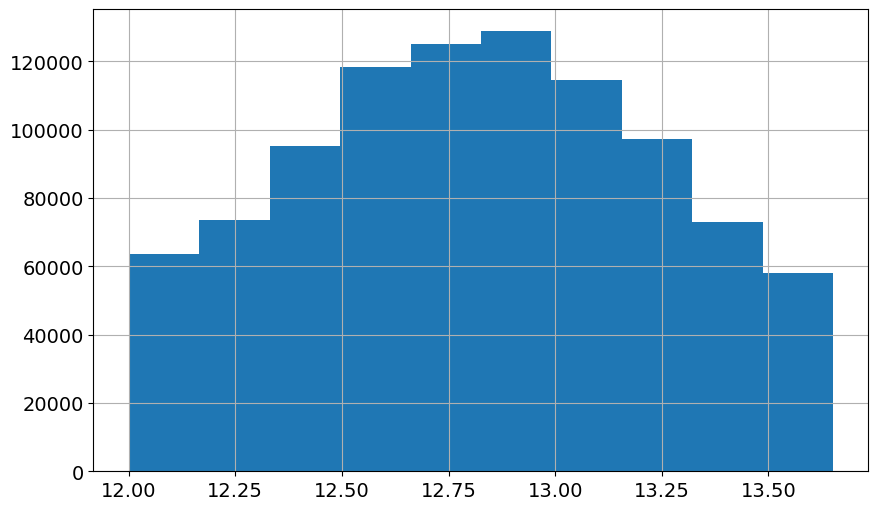

In [39]:
df.price.hist()

In [40]:

dep_var= 'price'
df[dep_var].describe()
skew = df['price'].skew()
print(f' Skewness of the target, price: { skew }')



 Skewness of the target, price: 0.0012445268706183545


<Axes: >

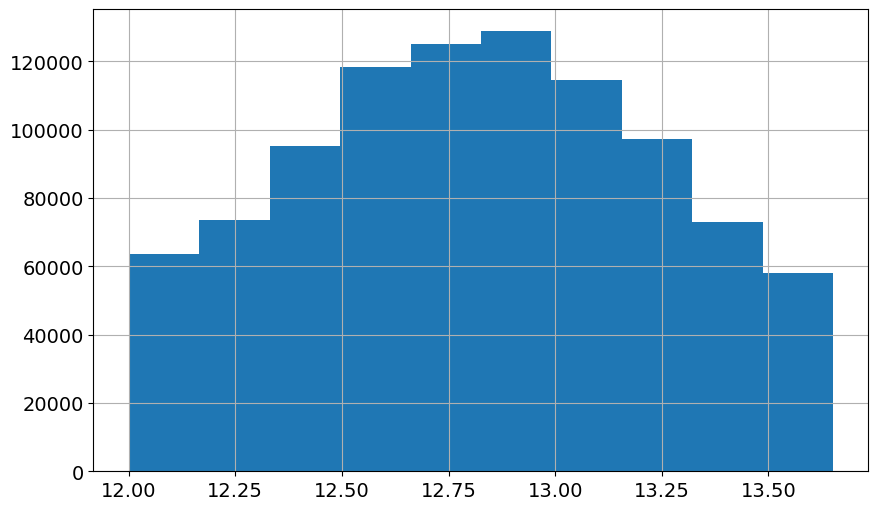

In [41]:
df.price.hist()

In [42]:
Q1 = df['bed'].quantile(0.25)
Q3 = df['bed'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
lower_bound , upper_bound

df_2 = df.copy()
df_2['bed'] = df_2['bed'].clip(upper=6)

In [43]:
df_2['price'].skew()


0.0012445268706183545

In [44]:
Q1 = df['bath'].quantile(0.25)
Q3 = df['bath'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
lower_bound , upper_bound

(0.5, 4.5)

In [45]:
df_2['bath'] = df_2['bath'].clip(upper=5)


In [46]:
Q1 = df['house_size'].quantile(0.25)
Q3 = df['house_size'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR 
upper_bound = Q3 + 1.5 * IQR 
lower_bound , upper_bound

(125.0, 3461.0)

In [47]:
df_2.house_size.describe()

count    947711.000000
mean       1867.426519
std        1344.423102
min         100.000000
25%        1376.000000
50%        1701.000000
75%        2210.000000
max      800900.000000
Name: house_size, dtype: float64

In [48]:
# anything lower than 800 square feet is not realistic to live in, so replace it will 800
df_2.loc[df_2['house_size'] < 800,'house_size'] = 800

In [49]:
df_2['house_size'] = df_2['house_size'].clip(upper=upper_bound)

In [50]:
df_2['house_size'] = df_2['house_size'] * 0.092903

In [51]:
df_2['acre_lot'] = df_2['acre_lot'] *4046.86

In [52]:
df_2.rename(columns={'acre_lot': 'land_size'}, inplace=True)

In [53]:
df_2[['land_size','house_size']].describe()

,land_size,house_size
count,947711.000000,947711.000000
mean,843.419546,171.131352
std,296.692430,61.060630
min,242.811600,74.322400
25%,607.029000,127.834528
50%,890.309200,158.028003
75%,1052.183600,205.315630
max,1578.275400,321.537283


In [54]:
df_2.price.skew()

0.0012445268706183545

### the data is cleaned, we do not have any null values, but we have outliers this does not really matters since we will be using a randomForest

In [55]:
df = df_2.copy()

In [56]:
df.describe() # limitation, land size mean is wayyy larger than house size, is it something related to urban areas or what ? 

,price,bed,bath,land_size,zip_code,house_size
count,947711.000000,947711.000000,947711.000000,947711.000000,947711.000000,947711.000000
mean,12.821715,3.206713,2.352889,843.419546,53864.220250,171.131352
std,0.416950,0.955199,0.817503,296.692430,29381.707055,61.060630
min,12.000278,1.000000,1.000000,242.811600,602.000000,74.322400
25%,12.505807,3.000000,2.000000,607.029000,30180.000000,127.834528
50%,12.821258,3.000000,2.000000,890.309200,54650.000000,158.028003
75%,13.134392,4.000000,3.000000,1052.183600,79602.000000,205.315630
max,13.651950,6.000000,5.000000,1578.275400,99923.000000,321.537283


In [57]:
df[dep_var].describe()

count    947711.000000
mean         12.821715
std           0.416950
min          12.000278
25%          12.505807
50%          12.821258
75%          13.134392
max          13.651950
Name: price, dtype: float64

# Working with a sample of the data

<Axes: >

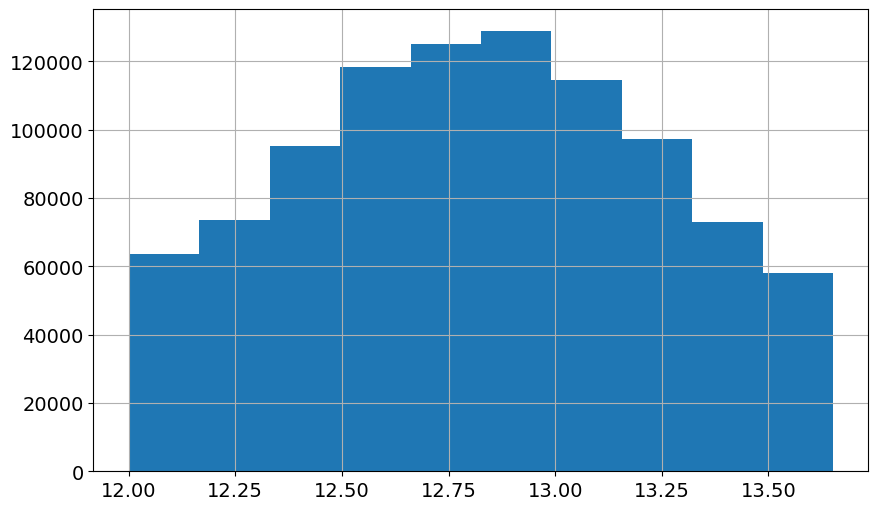

In [58]:
df.price.hist()

In [59]:
df

,status,price,bed,bath,land_size,city,state,zip_code,house_size
16,for_sale,12.367341,4.0,4.0,890.3092,Mayaguez,Puerto Rico,680.0,320.515350
21,for_sale,12.013701,6.0,3.0,404.6860,Moca,Puerto Rico,676.0,278.709000
25,for_sale,12.449019,3.0,2.0,1133.1208,San Sebastian,Puerto Rico,685.0,139.354500
26,for_sale,12.959844,4.0,3.0,1214.0580,Ponce,Puerto Rico,730.0,278.709000
31,for_sale,12.323856,5.0,4.0,485.6232,Ponce,Puerto Rico,717.0,148.644800
...,...,...,...,...,...,...,...,...,...
2226376,sold,12.736407,4.0,2.0,809.3720,Richland,Washington,99354.0,258.270340
2226377,sold,12.793581,4.0,2.0,1335.4638,Richland,Washington,99354.0,321.537283
2226378,sold,12.765688,3.0,2.0,404.6860,Richland,Washington,99354.0,150.131248
2226380,sold,12.100156,2.0,1.0,364.2174,Richland,Washington,99354.0,86.678499


In [60]:
training_data = 937411
test_data = training_data + 10000


df_100k = df[:training_data]
df_test = df[training_data:test_data]

In [83]:
states = df_100k['zip_code'].unique()
states.max(),states.min()

(99923.0, 602.0)

In [89]:
df_100k['state'].unique()

array(['Puerto Rico', 'Virgin Islands', 'Massachusetts', 'Connecticut', 'New Jersey', 'New Hampshire', 'Vermont', 'New York', 'Rhode Island', 'Wyoming', 'Virginia', 'Maine', 'Georgia',
       'Pennsylvania', 'Delaware', 'West Virginia', 'Ohio', 'Maryland', 'District of Columbia', 'Wisconsin', 'North Carolina', 'South Carolina', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama',
       'Florida', 'Missouri', 'Arkansas', 'Louisiana', 'Indiana', 'Illinois', 'Michigan', 'Iowa', 'Minnesota', 'South Dakota', 'Nebraska', 'Texas', 'North Dakota', 'Montana', 'Idaho', 'Kansas',
       'Oklahoma', 'Colorado', 'New Mexico', 'Utah', 'Nevada', 'Washington', 'Oregon', 'Arizona', 'California', 'Hawaii', 'Guam', 'Alaska'], dtype=object)

In [100]:
df_100k[df_100k['price'] < 12.1]

,status,price,bed,bath,land_size,city,state,zip_code,house_size
21,for_sale,12.013701,6.0,3.0,404.6860,Moca,Puerto Rico,676.0,278.709000
168,for_sale,12.013701,5.0,3.0,445.1546,Anasco,Puerto Rico,610.0,216.185281
191,for_sale,12.095141,5.0,3.0,323.7488,Arecibo,Puerto Rico,612.0,204.386600
203,for_sale,12.031719,4.0,3.0,1011.7150,Arecibo,Puerto Rico,612.0,148.644800
223,for_sale,12.071970,3.0,2.0,323.7488,Barceloneta,Puerto Rico,617.0,111.019085
...,...,...,...,...,...,...,...,...,...
2208668,sold,12.095141,3.0,2.0,849.8406,Port Ludlow,Washington,98365.0,158.028003
2208730,sold,12.095141,2.0,2.0,1052.1836,Puyallup,Washington,98372.0,140.469336
2208746,sold,12.013701,2.0,1.0,445.1546,Puyallup,Washington,98375.0,74.322400
2209382,sold,12.042965,3.0,2.0,1052.1836,Port Orchard,Washington,98367.0,98.105568


In [ ]:
cities = ['Mayaguez', 'Moca', 'San Sebastian''Agawam', 'Amherst', 'Buckland',
          'Montague', 'Blytheville', 'Gosnell', 'West Memphis', 'Marion', 'Horseshoe Lake']

<Axes: >

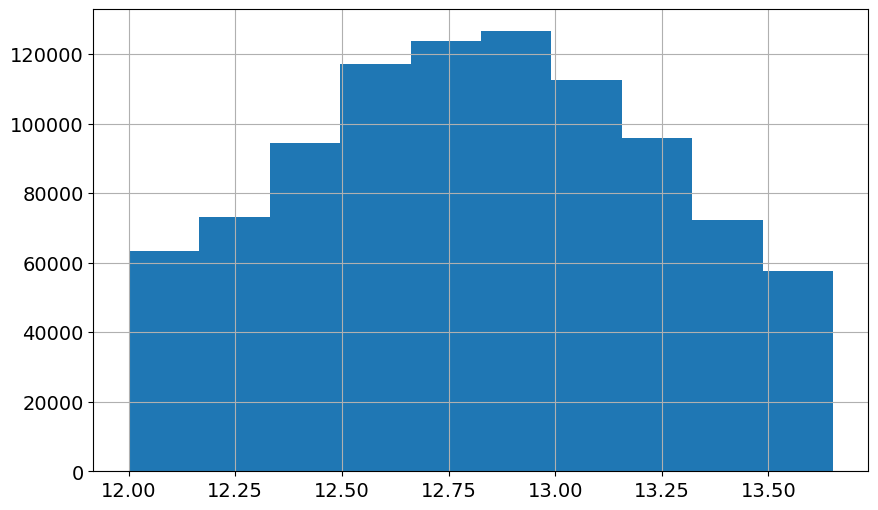

In [842]:
df_100k[dep_var].hist()

## Splitting the Data into 70%, 30% 

In [843]:
splits = RandomSplitter(valid_pct=0.3,seed=42)(df_100k)

In [844]:
len(splits[0]),len(splits[1]),len(df_100k)

(656188, 281223, 937411)

## Proceesing the data 

In [845]:
procs = [Categorify,FillMissing]

In [846]:
cont, cat = cont_cat_split(df,1,dep_var=dep_var)

In [847]:
cont

['bed', 'bath', 'land_size', 'zip_code', 'house_size']

In [848]:
cat

['status', 'city', 'state']

In [849]:
to = TabularPandas(df_100k, procs,cat, cont,y_names=dep_var,splits=splits)

In [850]:
df_100k

,status,price,bed,bath,land_size,city,state,zip_code,house_size
16,for_sale,12.367341,4.0,4.0,890.3092,Mayaguez,Puerto Rico,680.0,320.515350
21,for_sale,12.013701,6.0,3.0,404.6860,Moca,Puerto Rico,676.0,278.709000
25,for_sale,12.449019,3.0,2.0,1133.1208,San Sebastian,Puerto Rico,685.0,139.354500
26,for_sale,12.959844,4.0,3.0,1214.0580,Ponce,Puerto Rico,730.0,278.709000
31,for_sale,12.323856,5.0,4.0,485.6232,Ponce,Puerto Rico,717.0,148.644800
...,...,...,...,...,...,...,...,...,...
2209598,sold,12.905182,3.0,2.0,404.6860,Port Orchard,Washington,98367.0,136.567410
2209602,sold,13.049793,4.0,3.0,323.7488,Port Orchard,Washington,98366.0,198.998226
2209606,sold,13.514091,4.0,3.0,1456.8696,Allyn,Washington,98524.0,237.924583
2209607,sold,12.847663,3.0,2.0,890.3092,Bremerton,Washington,98312.0,120.402288


# CheckPoint

save what you have made, it's good to save your results from time to time


In [851]:
save_pickle('./to_house.pkl',to)

### Create a Decision Tree

In [852]:
to = load_pickle('./to_house.pkl')

extract the training and validation sets

In [853]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y 

In [854]:
valid_xs

,status,city,state,bed,bath,land_size,zip_code,house_size
100085,1,6200,32,2.0,2.0,971.246399,8330.0,173.728607
1375997,1,10423,51,4.0,3.0,283.280212,98661.0,203.271759
2081960,3,4406,5,3.0,2.0,526.091797,92344.0,107.674576
1134990,1,2955,46,4.0,4.0,930.777771,79932.0,267.374847
1899828,3,2925,38,3.0,4.0,1052.183594,73013.0,292.458649
...,...,...,...,...,...,...,...,...
2165427,3,8821,5,4.0,2.0,890.309204,95820.0,168.247330
1856793,3,7140,15,4.0,2.0,445.154602,60706.0,130.064194
1897659,3,732,4,2.0,2.0,768.903381,72712.0,117.801003
1943697,3,3480,46,2.0,1.0,849.840576,76108.0,104.608780


In [855]:
valid_y

100085     12.926377
1375997    13.170963
2081960    12.691581
1134990    13.303017
1899828    12.863593
             ...    
2165427    13.079456
1856793    12.992254
1897659    13.171153
1943697    12.323855
1905814    12.100157
Name: price, Length: 281223, dtype: float32

In [856]:
from sklearn.tree import DecisionTreeRegressor

In [857]:
m = DecisionTreeRegressor()
m.fit(xs,y)

DecisionTreeRegressor()

### LOSS FUNCTION

ROOT MEAN SQUARE LOG ERROR

log error --> because we took the log of the price

In [858]:
# it is good to make your loss function from scratch for you to see how math's
# will be directly implemented inside the work that you have at hand
# let's make the rmse

import math
def r_mse(pred, y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m,xs,y): return r_mse(m.predict(xs),y)

In [859]:
m_rmse(m,xs,y), m_rmse(m,valid_xs,valid_y)

(0.051989, 0.281995)

why the validation error is higher than the training error ? what's happening? 

In [860]:
m.get_n_leaves(), len(xs)

(565224, 656188)

we have `70,000` leafs, and the decision tree have `60427` leafs which means the decision tree literally memorized the training dataset, which is known in deep learning as `overfitting`

In [861]:
m = DecisionTreeRegressor(min_samples_leaf=25).fit(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.22191, 0.243914)

now they are closer to each other, and that's just better !

In [862]:
m.get_n_leaves() # very good result

19860

## Creating a RandomForest

## later:

- try improving this randomForest Regressor with better parameters

In [863]:
from sklearn.ensemble import RandomForestRegressor

# we will make a function to traverse and try different parameters for the RandomForest
# n_estimators = 40 --> number of trees, if you have time and enough sleep increase this number
# max_samples = 200,000 rows , but we have 192,000 train datapoints , let's see if anything here breaks 
# max_features = 0.5 --> randomly take half the columns to train a single tree
# min_samples_leaf= 5 --> the final leaf node shall contain at least 5 rows of data (5 airplane tickets)
# n_jobs = -1 --> tell sklearn to use all of our CPU brain power to run this in parallel
# oob_score = True --> explain this later

# things to test here, increase the # of trees, use sklearn default max_feature, use the min_samples_leaf default of sklearn
# then report your findings

def rf(xs, y, n_estimators=40, max_samples=656188, max_features=0.5, min_samples_leaf=4, **kwargs):
    return RandomForestRegressor(n_estimators=n_estimators, max_samples=max_samples, 
                                 max_features=max_features, min_samples_leaf=min_samples_leaf,
                                 oob_score=True , n_jobs=-1).fit(xs,y)

In [864]:
m = rf(xs,y)

In [865]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.166484, 0.218065)

In [866]:
df_100k.price.describe()

count    937411.000000
mean         12.820374
std           0.417607
min          12.000278
25%          12.502467
50%          12.820988
75%          13.132314
max          13.651950
Name: price, dtype: float64

## Feature Importances

In [867]:
def rf_feature_importance(m,df):
  return pd.DataFrame(
    {'cols':df.columns, 'imp':m.feature_importances_}
  ).sort_values('imp',ascending=False)
  

In [868]:
fi = rf_feature_importance(m,xs)
fi

,cols,imp
6,zip_code,0.415062
7,house_size,0.236815
1,city,0.088251
2,state,0.083996
4,bath,0.081842
5,land_size,0.051763
3,bed,0.025267
0,status,0.017003


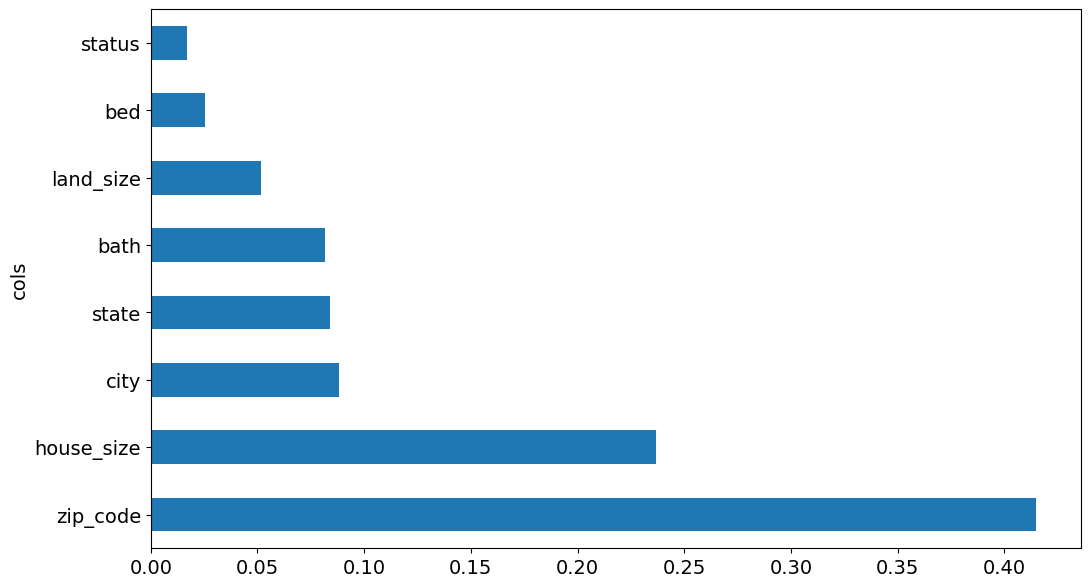

In [869]:
def plot_fi(fi): 
  return fi.plot('cols','imp','barh', figsize=(12,7),legend=False)

plot_fi(fi);

In [870]:
to_keep = fi[fi.imp>0.005].cols
to_keep

6      zip_code
7    house_size
1          city
2         state
4          bath
5     land_size
3           bed
0        status
Name: cols, dtype: object

In [871]:
len(to_keep) , len(fi)

(8, 8)

In [872]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

valid_xs_imp.columns.tolist()

['zip_code',
 'house_size',
 'city',
 'state',
 'bath',
 'land_size',
 'bed',
 'status']

In [873]:
m = rf(xs_imp, y)

In [874]:
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.166873, 0.218643)

there is not much of a difference in error rate for with the new columns

In [875]:
xs_final = xs_imp
valid_xs_final = valid_xs_imp 

In [876]:
save_pickle('./xs_final_house.pkl', xs_final)
save_pickle('./valid_xs_final_house.pkl', valid_xs_final)


# Final Chosen Features

In [877]:
xs = load_pickle('./xs_final_house.pkl')
valid_xs = load_pickle('./valid_xs_final_house.pkl')

In [878]:
# make sure everything is going well
m = rf(xs,y)

In [879]:
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.166613, 0.218442)

every is good, the error is the same as above

In [880]:
! pip install treeinterpreter waterfallcharts

In [881]:
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

In [882]:
row = valid_xs.iloc[:5]

In [883]:
prediction,bias,contributions = treeinterpreter.predict(m,row.values)

In [884]:
prediction[1],bias[1],contributions[1].sum()

(array([13.22214679]), 12.820508831768457, 0.40163795877336683)

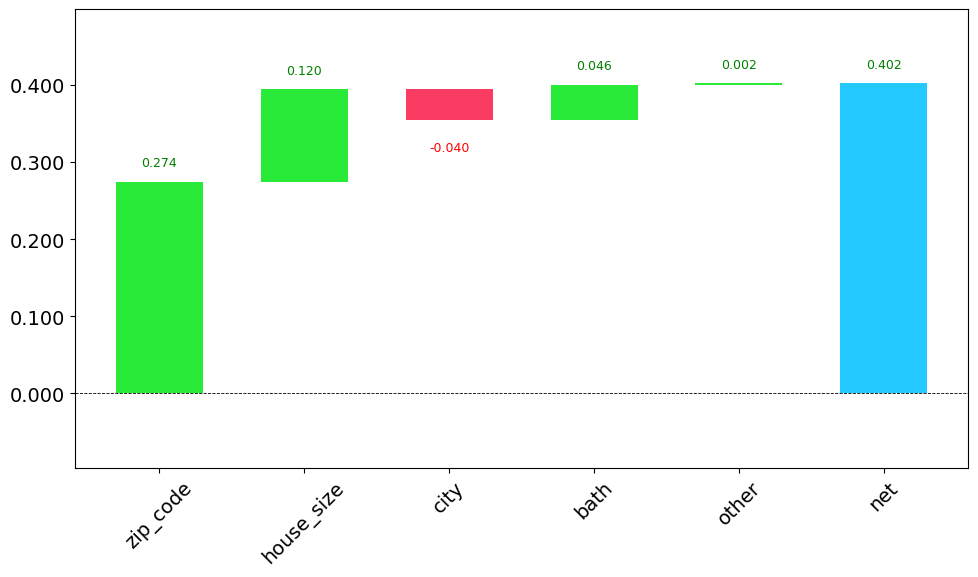

In [885]:
# ';' -> used to hide the unecessary outputs
waterfall(
  valid_xs.columns, contributions[1], threshold=0.08,
  rotation_value=45, formatting='{:.3f}'
  );

## edit this explanation later on

for a particular row of data, the following attributes help predict the flight ticket price in the following way: 
the class caused the ticket price to go down by - 0.612 then the days_left allowed the price to go higher with a +0.521 then the airline also pushed the price higher, then the duration pushed the price higher, other factors contributed a litte to push the price higher.

this is a good analysis, it represents what really happens in the real world, economy classes are generally cheaper, the days left to a flight generally also makes the price in the real world higher, then the airline pushes the price even higher in the real world and our model seems to think like a human, very nice analysis

this is analysis is good in 'production settings' where if the user asks why the price is high or low, we have this sample data that can provide the answer of what features cause the price to go up or down and by how much, very nice. 

In [886]:
test_xs = df_test.drop(columns=['price'])
test_xs

,status,bed,bath,land_size,city,state,zip_code,house_size
2209609,sold,3.0,3.0,1335.4638,Port Orchard,Washington,98366.0,177.073118
2209613,sold,3.0,2.0,1173.5894,Belfair,Washington,98528.0,115.942944
2209614,sold,1.0,1.0,728.4348,Port Orchard,Washington,98366.0,74.322400
2209619,sold,4.0,3.0,566.5604,Bremerton,Washington,98312.0,282.518023
2209620,sold,2.0,2.0,1011.7150,Bremerton,Washington,98311.0,178.373760
...,...,...,...,...,...,...,...,...
2225937,sold,3.0,2.0,728.4348,Richland,Washington,99352.0,181.625365
2225938,sold,3.0,2.0,607.0290,Richland,Washington,99352.0,158.306712
2225939,sold,3.0,2.0,607.0290,Richland,Washington,99352.0,153.940271
2225940,sold,4.0,3.0,971.2464,Richland,Washington,99352.0,231.514276


In [887]:
dl_test = to.dataloaders().test_dl(df_test)
xs_test, y_test = dl_test.train.xs, dl_test.train.y
xs_test = xs_test[xs.columns.to_list()]

In [888]:
# the test set shows you how well you are doing
# i can say we are doing pretty well
m_rmse(m,xs_test, y_test)

0.215582

### USING A NEURAL NETWORK

In [889]:
df_nn = df_100k.copy()
df_nn

,status,price,bed,bath,land_size,city,state,zip_code,house_size
16,for_sale,12.367341,4.0,4.0,890.3092,Mayaguez,Puerto Rico,680.0,320.515350
21,for_sale,12.013701,6.0,3.0,404.6860,Moca,Puerto Rico,676.0,278.709000
25,for_sale,12.449019,3.0,2.0,1133.1208,San Sebastian,Puerto Rico,685.0,139.354500
26,for_sale,12.959844,4.0,3.0,1214.0580,Ponce,Puerto Rico,730.0,278.709000
31,for_sale,12.323856,5.0,4.0,485.6232,Ponce,Puerto Rico,717.0,148.644800
...,...,...,...,...,...,...,...,...,...
2209598,sold,12.905182,3.0,2.0,404.6860,Port Orchard,Washington,98367.0,136.567410
2209602,sold,13.049793,4.0,3.0,323.7488,Port Orchard,Washington,98366.0,198.998226
2209606,sold,13.514091,4.0,3.0,1456.8696,Allyn,Washington,98524.0,237.924583
2209607,sold,12.847663,3.0,2.0,890.3092,Bremerton,Washington,98312.0,120.402288


In [890]:
df_nn_final = df_nn[xs.columns.to_list() + [dep_var]]

In [891]:
df_nn_final

,zip_code,house_size,city,state,bath,land_size,bed,status,price
16,680.0,320.515350,Mayaguez,Puerto Rico,4.0,890.3092,4.0,for_sale,12.367341
21,676.0,278.709000,Moca,Puerto Rico,3.0,404.6860,6.0,for_sale,12.013701
25,685.0,139.354500,San Sebastian,Puerto Rico,2.0,1133.1208,3.0,for_sale,12.449019
26,730.0,278.709000,Ponce,Puerto Rico,3.0,1214.0580,4.0,for_sale,12.959844
31,717.0,148.644800,Ponce,Puerto Rico,4.0,485.6232,5.0,for_sale,12.323856
...,...,...,...,...,...,...,...,...,...
2209598,98367.0,136.567410,Port Orchard,Washington,2.0,404.6860,3.0,sold,12.905182
2209602,98366.0,198.998226,Port Orchard,Washington,3.0,323.7488,4.0,sold,13.049793
2209606,98524.0,237.924583,Allyn,Washington,3.0,1456.8696,4.0,sold,13.514091
2209607,98312.0,120.402288,Bremerton,Washington,2.0,890.3092,3.0,sold,12.847663


for the neural networks, we cannot just use the normal hot encoding, this will use alot more memory and the model can't really find relationships from this kind of categorifying things compared with the Embeddings.

Embeddings will allow the features to have more meaning. "add more explanation here later"

anything lower than 9000 unique values, use Embeddings for the columns that are categories

In [892]:
cont_nn, cat_nn = cont_cat_split(df_nn_final, max_card=9000, dep_var=dep_var)

In [893]:
cont_nn

['zip_code', 'house_size', 'bath', 'land_size', 'bed']

In [894]:
cat_nn

['city', 'state', 'status']

In [895]:
df_nn_final[cat_nn].nunique()

city      11344
state        54
status        3
dtype: int64

The categories here are lower than 9000 unique values which is desent and doing pretty well you know 

In [896]:
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn_final, procs_nn, cat_nn,
                      cont_nn, splits=splits, y_names=dep_var)

In [897]:
dls = to_nn.dataloaders(1024) # since tabular data do not use much GPU RAM

In [898]:
y = to_nn.train.y

In [899]:
y.min(),y.max()

(12.0002775, 13.65195)

In [900]:
learn = tabular_learner(dls, y_range=(12,13.7), layers=[100,50],
                        n_out= 1, loss_func=F.mse_loss
                        )

so what is inside a neural network ? let's see

In [901]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(11345, 298)
    (1): Embedding(55, 15)
    (2): Embedding(4, 3)
  )
  (emb_drop): Dropout(p=0.0, inplace=False)
  (bn_cont): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): LinBnDrop(
      (0): Linear(in_features=321, out_features=100, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): LinBnDrop(
      (0): Linear(in_features=100, out_features=50, bias=False)
      (1): ReLU(inplace=True)
      (2): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): LinBnDrop(
      (0): Linear(in_features=50, out_features=1, bias=True)
    )
    (3): fastai.layers.SigmoidRange(low=12, high=13.7)
  )
)

SuggestedLRs(valley=0.0020892962347716093, slide=0.05754399299621582)

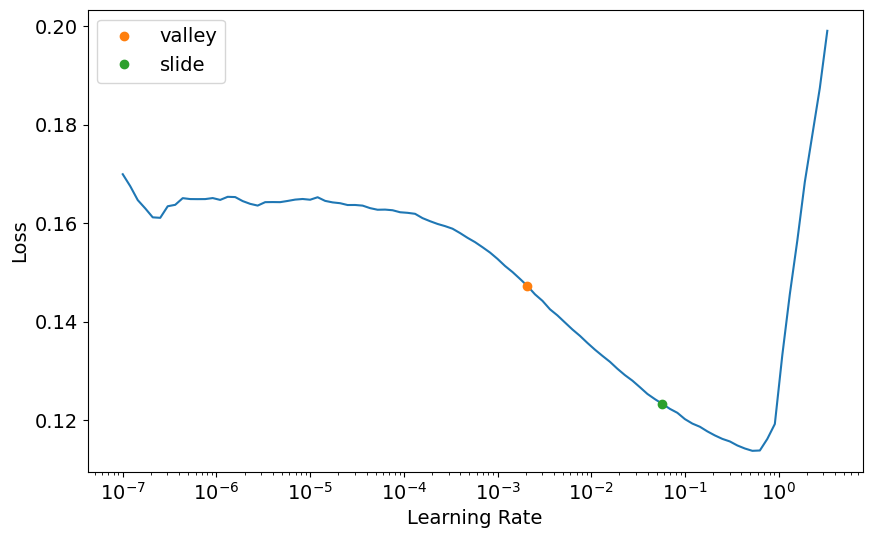

In [902]:
learn.lr_find(suggest_funcs=(valley,slide))

In [903]:
learn = tabular_learner(dls, y_range=(12,13.7), layers=[100,50],
                        n_out= 1, loss_func=F.mse_loss
                        )
learn.fit_one_cycle(10, 1e-1, wd=0.08) # weight decay


epoch,train_loss,valid_loss,time
0,0.060585,0.063738,00:09
1,0.063716,0.066368,00:09
2,0.064450,0.067249,00:09
3,0.064100,0.065327,00:08
4,0.062123,0.065299,00:09
5,0.060243,0.062681,00:08
6,0.056700,0.058991,00:08
7,0.052448,0.056129,00:08
8,0.048505,0.052281,00:08
9,0.045303,0.050552,00:09


experimenting

valid_loss  ||   wd 

0.238735    || 0.01

0.258378    || 0.02

0.220982    || 0.03

0.226851    || 0.06

0.218231    || 0.08




In [904]:
preds, targets = learn.get_preds()

r_mse(preds, targets)

0.224837

In [905]:
# export the whole model
learn.export('nn.pkl')
save_pickle('./to_nn.pkl',to_nn)

## Testing the NN on the Test Set

In [906]:
xs_test = df_test.drop(columns=['price'])
test_y_tars = df_test['price']

In [907]:
dl_test = learn.dls.test_dl(xs_test)


In [908]:
# the test set shows you how well you are doing
# i can say we are doing pretty well
preds , _ = learn.get_preds(dl=dl_test)


In [909]:
r_mse(to_np(preds.squeeze()),test_y_tars)

0.208291

this result is good as well, so we now have 2 models, random forests and the deep learning neural network

## Using XGboost

In [910]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

In [911]:
to = load_pickle('./to_house.pkl')
y = to.train.y
valid_y = to.valid.y
xs = load_pickle('./xs_final_house.pkl')
valid_xs = load_pickle('./valid_xs_final_house.pkl')

In [912]:

def xgboost(xs,y,learning_rate=0.3, n_estimators=700,
                  max_depth=10, subsample=0.9, colsample_bytree=0.7,min_child_weight=3,**params):
  return XGBRegressor(random_state=42, n_jobs=-1, 
                       learning_rate= learning_rate, n_estimators= n_estimators,
                       max_depth=max_depth, subsample=subsample, colsample_bytree=colsample_bytree,
                       min_child_weight = min_child_weight, device='cuda').fit(xs,y)

In [913]:
m_rf = rf(xs,y)

In [914]:
# i think we can do better
# use more trees
xgb = xgboost(xs, y, learning_rate=0.02,
              n_estimators=11000, colsample_bytree=0.7, subsample=0.7,
              max_depth=10, min_child_weight=3)


In [915]:
preds_xgb = xgb.predict(valid_xs)
preds_rf = m_rf.predict(valid_xs)

In [916]:
r_mse(preds_rf,valid_y),r_mse(preds_xgb,valid_y)

(0.218324, 0.211628)

## finding the best settings for  XGBOOST
xgboost 1000 trees, 0.05 --> 0.40

xgboost 700 trees, 0.02 --> 0.409153

xgboost(xs,y, learning_rate=0.02,n_estimators=1200,max_depth=12) -- 0.403273

xgboost(xs,y, learning_rate=0.02,n_estimators=1400,colsample_bytree=0.9,) -- 0.400886

xgboost(xs,y, learning_rate=0.02,n_estimators=1396,colsample_bytree=0.9,)

In [917]:
dl_test = to.dataloaders().test_dl(df_test)
xs_test, y_test = dl_test.train.xs, dl_test.train.y
xs_test = xs_test[xs.columns.to_list()]
# the test set shows you how well you are doing
# i can say we are doing pretty well
m_rmse(m_rf,xs_test, y_test),m_rmse(xgb,xs_test, y_test)

(0.214239, 0.205222)

# Final Results

In [918]:
# trees data -- LOAD AND TRAIN THE TREES

to = load_pickle('./to_house.pkl')
y = to.train.y
valid_y = to.valid.y
xs = load_pickle('./xs_final_house.pkl')
valid_xs = load_pickle('./valid_xs_final_house.pkl')

In [919]:
xgb = xgboost(xs, y, learning_rate=0.02,
              n_estimators=12000, colsample_bytree=0.7, subsample=0.7,
              max_depth=10)

In [920]:
m_rf = rf(xs, y)

In [921]:
# TESTING THE BOOSTING AND BAGGING METHODS


dl_test = to.dataloaders().test_dl(df_test)
xs_test, y_test = dl_test.train.xs, dl_test.train.y
xs_test = xs_test[xs.columns.to_list()]

RF_test = m_rmse(m_rf, xs_test, y_test)
XBG_test = m_rmse(xgb, xs_test, y_test)


# neural network
learner = load_learner('nn.pkl')
to_nn = load_pickle('./to_nn.pkl')

nn_xs_test = df_test.drop(columns=['price'])
nn_targets_test = df_test['price']
dl_nn_test = learner.dls.test_dl(nn_xs_test)

# the test set shows you how well you are doing
# i can say we are doing pretty well
preds, _ = learner.get_preds(dl=dl_nn_test)

nn_test_result = r_mse(to_np(preds.squeeze()), nn_targets_test)

print(f'NN Test Result: { nn_test_result } ||  Random Forest Test Result: { RF_test  }  || XGBOOST Test Result: { XBG_test } ')

NN Test Result: 0.208291 ||  Random Forest Test Result: 0.212776  || XGBOOST Test Result: 0.205824 


### Trying the NN embedding on the random forest model and on the XGBoost

this shows that we need to clean the data even further

In [922]:
embed_xs , embed_y = to_nn.train.xs , to_nn.train.y
embed_valid_xs , embed_valid_y = to_nn.valid.xs , to_nn.valid.y



In [923]:
xgb = xgboost(embed_xs, embed_y, learning_rate=0.02,
              n_estimators=12000, colsample_bytree=0.7, subsample=0.7,
              max_depth=10)
m_rf = rf(embed_xs, embed_y)

In [924]:
m_rmse(xgb,embed_valid_xs, embed_valid_y),m_rmse(m_rf,embed_valid_xs, embed_valid_y)

(0.211662, 0.218162)

In [925]:
embeds_test = dl_nn_test.train.xs

In [926]:
m_rmse(m_rf,embeds_test, nn_targets_test), m_rmse(xgb,embeds_test, nn_targets_test), 

(0.2155, 0.207143)

In [927]:
def tree_load_data():
    
    """
    Loads the data for the trees in order to train them using it
    future addition may include adding the actual df, then making the training set
    and the validation set

    Returns:
        xs: training data
        y: training target 
        valid_xs: validation data
        valid_y: validation target 
        xs_test: testings data,
        y_test = testing target
        
    """

    # trees data -- LOAD AND TRAIN THE TREES
    to = load_pickle('./to_house.pkl')
    y = to.train.y
    valid_y = to.valid.y
    xs = load_pickle('./xs_final_house.pkl')
    valid_xs = load_pickle('./valid_xs_final_house.pkl')

    dl_test = to.dataloaders().test_dl(df_test)
    xs_test, y_test = dl_test.train.xs, dl_test.train.y
    xs_test = xs_test[xs.columns.to_list()]
    data = dict(
                xs = xs,
                y = y,
                valid_xs = valid_xs,
                valid_y = valid_y,
                xs_test = xs_test,
                y_test = y_test)
    return data

In [928]:
def train_and_load_tree(xs, y):
  """
  This function should train and return to us train XGBOOST and Random Forests
  by training them on the data we pass to them. 
  """
  
  xgb = xgboost(xs, y, learning_rate=0.02,
              n_estimators=700, colsample_bytree=0.7, subsample=0.7,
              max_depth=10)
  m_rf = rf(xs, y)  
  
  data = dict(xgb=xgb, rft = m_rf)
  
  return data

In [929]:
def nn():
  # neural network
  learner = load_learner('nn.pkl')
  to_nn = load_pickle('./to_nn.pkl') # can be used later for it's embeddings

  nn_xs_test = df_test.drop(columns=['price'])
  nn_targets_test = df_test['price']
  dl_nn_test = learner.dls.test_dl(nn_xs_test)
  
  data = dict(
    learner = learner,
    dl = dl_nn_test,
    to_nn = to_nn
  )
  return data

In [930]:
nn = nn()
data = tree_load_data()

In [931]:
tree_models = train_and_load_tree(data['xs'], data['y'])


In [932]:
preds_nn, _ = nn['learner'].get_preds(dl=nn['dl'])
preds_nn = to_np(preds_nn.squeeze())
pred_rf = tree_models['rft'].predict(data['xs_test'])
pred_xgb = tree_models['xgb'].predict(data['xs_test'])


In [933]:
r_mse(preds_nn, data['y_test']), r_mse(pred_rf,data['y_test']), r_mse(pred_xgb,data['y_test'])

(0.208291, 0.215218, 0.214723)

In [934]:

combined_preds = [preds_nn, pred_rf, pred_xgb]
preds  = np.stack(combined_preds).mean(0)
y_test = data['y_test']
r_mse(preds,y_test)

0.202169

In [935]:
combined_predictions = [
    preds_nn * 0.5,
    pred_rf * 0.25,
    pred_xgb * 0.25,
]

# Compute the weighted average
preds_weighted = np.sum(combined_predictions, axis=0)

# Calculate RMSLE of the ensemble
ensemble_rmsle = r_mse(preds_weighted, y_test)
print(f"Weighted Ensemble RMSLE: {ensemble_rmsle}")


Weighted Ensemble RMSLE: 0.200306


In [936]:
np.exp(df.price).describe()

count    947711.000000
mean     403352.334221
std      167939.057155
min      162800.000000
25%      269900.000000
50%      370000.000000
75%      506050.500000
max      849115.000000
Name: price, dtype: float64

In [937]:
df.columns.to_list()

['status',
 'price',
 'bed',
 'bath',
 'land_size',
 'city',
 'state',
 'zip_code',
 'house_size']

In [938]:
df_100k.city.unique()

array(['Mayaguez', 'Moca', 'San Sebastian', ..., 'Decatur Island', 'Stuart Island', 'Bow'], dtype=object)

In [939]:
data = dict(
    status='for_sale',
    bed=6,
    bath=3,
    land_size=404.686,
    city='Moca',
    state='Puerto Rico',
    zip_code=676.0,
    house_size=278.709,
)
one_prediction = pd.DataFrame([data])
one_prediction

,status,bed,bath,land_size,city,state,zip_code,house_size
0,for_sale,6,3,404.686,Moca,Puerto Rico,676.0,278.709


In [940]:
df.iloc[[1]]

,status,price,bed,bath,land_size,city,state,zip_code,house_size
21,for_sale,12.013701,6.0,3.0,404.686,Moca,Puerto Rico,676.0,278.709


In [941]:
df.describe()

,price,bed,bath,land_size,zip_code,house_size
count,947711.000000,947711.000000,947711.000000,947711.000000,947711.000000,947711.000000
mean,12.821715,3.206713,2.352889,843.419546,53864.220250,171.131352
std,0.416950,0.955199,0.817503,296.692430,29381.707055,61.060630
min,12.000278,1.000000,1.000000,242.811600,602.000000,74.322400
25%,12.505807,3.000000,2.000000,607.029000,30180.000000,127.834528
50%,12.821258,3.000000,2.000000,890.309200,54650.000000,158.028003
75%,13.134392,4.000000,3.000000,1052.183600,79602.000000,205.315630
max,13.651950,6.000000,5.000000,1578.275400,99923.000000,321.537283


In [942]:
to = load_pickle('./to_house.pkl')
to.train.xs

,status,city,state,bed,bath,land_size,zip_code,house_size
2172542,3,8637,5,3.0,2.0,930.777771,95765.0,184.505356
528684,1,11139,10,4.0,2.0,485.623199,33884.0,169.826691
933594,1,9612,27,4.0,3.0,1537.806763,65810.0,321.537292
1113214,1,6213,46,3.0,2.0,809.372009,78501.0,321.537292
1140891,1,7278,6,4.0,4.0,1052.183594,80233.0,321.537292
...,...,...,...,...,...,...,...,...
854516,1,2473,15,4.0,4.0,1133.120850,60015.0,234.115555
1110391,1,8944,46,4.0,2.0,485.623199,78254.0,161.279602
1384775,1,5178,39,4.0,3.0,1052.183594,97601.0,277.779968
1242963,1,5477,33,4.0,2.0,687.966187,88001.0,166.946686


In [943]:
dl_prediction = to.dataloaders().test_dl(one_prediction)
xs_test = dl_prediction.train.xs
xs_test = xs_test[xs.columns.to_list()]
xs_test

dl_nn = nn['learner'].dls.test_dl(one_prediction)

In [944]:
one_target = df.iloc[[1]]['price']

In [945]:
pred_nn,_ = nn['learner'].get_preds(dl=dl_nn)

In [946]:
pred_rf = tree_models['rft'].predict(xs_test)
pred_xgb = tree_models['xgb'].predict(xs_test)
preds = to_np(pred_nn.squeeze())

In [947]:
r_mse(pred_rf,one_target),r_mse(pred_xgb,one_target),r_mse(preds,one_target)

(0.785229, 0.458664, 0.53452)

In [948]:

combined_predictions = [preds.item(),pred_xgb.item(),pred_rf.item()]
weights = [2,3,1]
preds  = np.average(combined_predictions,weights=weights)
preds

12.552077463866345

In [949]:
np.exp(preds).item()

282681.8852166065

In [ ]:
# import joblib
# export_data = dict(
#   learner = nn['learner'],
#   xgb = tree_models['xgb'],
#   rf = tree_models['rft'],
#   to = to)
# house_price_prediction = export_data

# joblib.dump(house_price_prediction,'price_pred.joblib')

['price_pred.joblib']

An error of 23,000$

### Final verdict

we have an error of RMSE: 0.206821 after the price column was transformed using the log. so this means that the error of the prediction of the ensemble of the models is off by 74,331 dollars on a scale of: 162,755 to 806,130 which is quite a large scale, and from here we need to understand our error in the problems of real estate: 

- the mean = 369700
- the  



In [950]:
# Assuming RMSE on the log scale is 0.206821
rmse_log = 0.201057
# Mean price from the original data
mean_price = df_100k['price'].mean()  # mean of the price column in log-scale
mean_price = np.exp(mean_price)

# Compute RMSE on the original scale
rmse_original = rmse_log * mean_price * np.exp(rmse_log**2 / 2)

print(f"RMSE in the original scale (dollars): {rmse_original}")


RMSE in the original scale (dollars): 75842.90463130818


`np.exp(rmse_log**2 / 2)` adjusts the error based on the spread of the data on the log scale.

In [951]:
df_100k['price'].describe()

count    937411.000000
mean         12.820374
std           0.417607
min          12.000278
25%          12.502467
50%          12.820988
75%          13.132314
max          13.651950
Name: price, dtype: float64

In [952]:
np.exp(12.820447), np.exp(12.000278), np.exp(13.651950), 

(369699.9464213336, 162800.04354077185, 849115.0767641028)

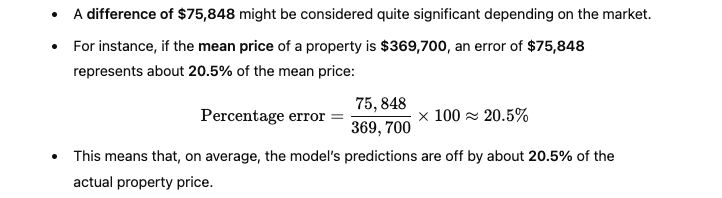